In [1]:
from fastai.vision import *

In [2]:
biwi = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi/'centers.pkl', 'rb'))

In [3]:
data = (PointsItemList.from_folder(biwi)
        .split_by_rand_pct(seed=42)
        .label_from_func(lambda o:fn2ctr[o.name])
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch()
        .normalize(imagenet_stats))

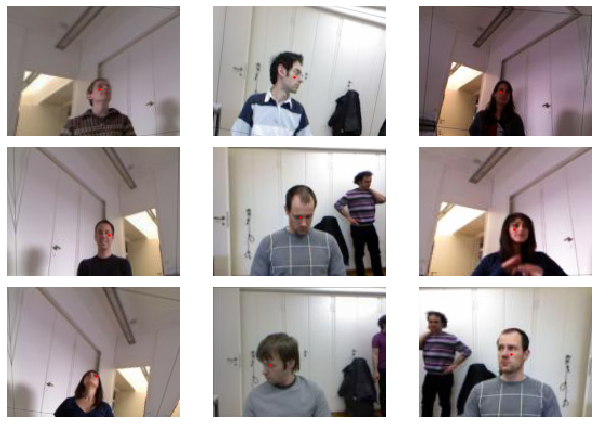

In [4]:
data.show_batch(rows=3, figsize=(9,6))

In [10]:
learn = cnn_learner(data, models.resnet18, lin_ftrs=[100], ps=0.05)
learn.fit_one_cycle(5, 5e-2)
learn.save('mini_train')
learn.load('mini_train')

epoch,train_loss,valid_loss,time
0,2.112246,8.048159,00:25
1,3.101722,48.254776,00:25
2,2.573422,17.998177,00:25
3,2.004995,2.068414,00:24
4,1.612650,0.440140,00:24


Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /Users/HenryDashwood/.fastai/data/biwi_sample;

Valid: LabelList (40 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /Users/HenryDashwood/.fastai/data/biwi_sample;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, paddi

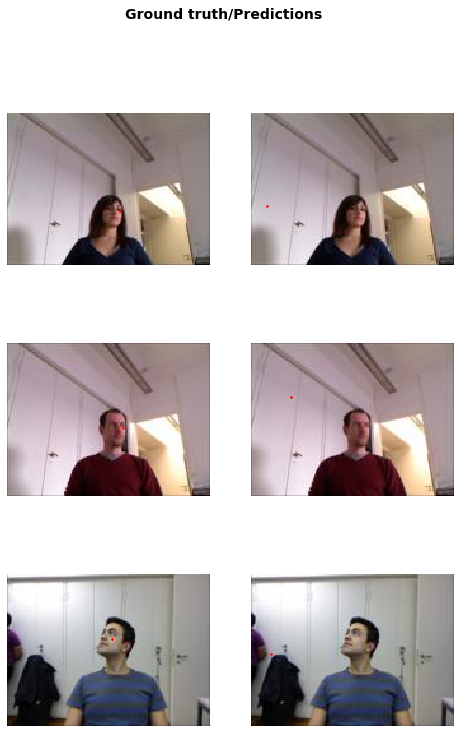

In [11]:
learn.show_results(rows=3)

### Bento Stuff

In [12]:
%%writefile regression_demo.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['fastai'])
@artifacts([FastaiModelArtifact('regression_demoer')])
class RegressionDemo(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.regression_demoer.predict(image)
        return str(result)

Overwriting regression_demo.py


In [13]:
# 1) import the custom BentoService defined above
from regression_demo import RegressionDemo

# 2) `pack` it with required artifacts
service = RegressionDemo.pack(regression_demoer=learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2019-10-28 23:46:05,313] INFO - Successfully saved Bento 'RegressionDemo:20191028234536_A5B693' to path: /Users/HenryDashwood/bentoml/repository/RegressionDemo/20191028234536_A5B693


In [14]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2019-10-28 23:46:57,763] WARNING - Module `regression_demo` already loaded, using existing imported module.
(ImagePoints (120, 160), tensor([[-0.6896, -0.7053]]), tensor([-0.6896, -0.7053]))


In [15]:
!pip install --upgrade {saved_path}

Processing /Users/HenryDashwood/bentoml/repository/RegressionDemo/20191028234536_A5B693
  Created wheel for RegressionDemo: filename=RegressionDemo-20191028234536_A5B693-cp37-none-any.whl size=41955039 sha256=9353c46a9e9db2098fa5ab22d707554251645c2a7053584a3bf990be414d2803
  Stored in directory: /private/var/folders/yl/c5z1v7897q3g9ywlj63pm0840000gn/T/pip-ephem-wheel-cache-fbrhaj77/wheels/21/ba/43/5d508cb4d590598e4e8b385c969f6b37b29adbf7d0b2f9b387
Successfully built RegressionDemo


In [17]:
!RegressionDemo predict --input=../data/resized_images/Abyssinian_1.jpg

(ImagePoints (120, 160), tensor([[ 0.0037, -0.1541]]), tensor([ 0.0037, -0.1541]))


In [18]:
bento_tag = '{name}:{version}'.format(name=service.name, version=service.version)
print(bento_tag)

RegressionDemo:20191028234536_A5B693


In [19]:
!bentoml --verbose deployment create regression-demo --bento {bento_tag} --platform aws-lambda --region us-east-1

[2019-10-28 23:50:53,703] DEBUG - Using BentoML with local Yatai server
[2019-10-28 23:50:53,945] DEBUG - Upgrading tables to the latest revision
[2019-10-28 23:50:56,961] DEBUG - Created temporary directory: /private/var/folders/yl/c5z1v7897q3g9ywlj63pm0840000gn/T/bentoml-temp-rt5lceyf
[2019-10-28 23:53:52,989] DEBUG - sls cmd output: Serverless: Generating boilerplate...
 _______                             __
|   _   .-----.----.--.--.-----.----|  .-----.-----.-----.
|   |___|  -__|   _|  |  |  -__|   _|  |  -__|__ --|__ --|
|____   |_____|__|  \___/|_____|__| |__|_____|_____|_____|
|   |   |             The Serverless Application Framework
|       |                           serverless.com, v1.53.0
 -------'

Serverless: Successfully generated boilerplate for template: "aws-python3"

[2019-10-28 23:53:54,422] INFO - Installing additional packages: serverless-python-requirements
[2019-10-28 23:54:06,225] DEBUG - sls cmd output: Serverless: Creating an empty package.json file in your

In [ ]:
# !bentoml --verbose deployments delete regression-demo --force

In [20]:
!pip freeze > requirements.txt